# Exploratory Data Analysis

In [1]:
#import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, date, timedelta
from pandas import DataFrame
import requests
import json
import random
import os.path

# RKI Case Numbers

In [2]:
#Download data set to explore case numbers
if os.path.isfile('bundesland_cases.csv'):
    bundesland_cases = pd.read_csv('bundesland_cases.csv', encoding='iso-8859-1')
else:
    url = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"
    data = pd.read_csv(url,
                     encoding= 'utf8', 
                     usecols=['Bundesland', 'AnzahlFall', 'Meldedatum'],
                     parse_dates=['Meldedatum'])
    bundesland_cases = data.groupby(['Bundesland', 'Meldedatum'], as_index = False)['AnzahlFall'].sum()
    bundesland_cases = bundesland_cases.set_index("Meldedatum").sort_index()
    bundesland_cases.to_csv("bundesland_cases.csv")
    
print(bundesland_cases)

                        Bundesland  AnzahlFall
Meldedatum                                    
2020-01-02     Nordrhein-Westfalen           1
2020-01-12     Nordrhein-Westfalen           1
2020-01-14     Nordrhein-Westfalen           1
2020-01-18             Brandenburg           1
2020-01-23                Saarland           1
2020-01-28                  Bayern           2
2020-01-28     Nordrhein-Westfalen           1
2020-01-29                  Bayern           2
2020-01-30     Nordrhein-Westfalen           1
2020-01-31                Saarland           1
2020-01-31                  Bayern           5
2020-02-03                  Bayern           1
2020-02-04           Niedersachsen           1
2020-02-04                  Bayern           3
2020-02-06                  Bayern           1
2020-02-07                  Bayern           1
2020-02-11                  Bayern           2
2020-02-12     Nordrhein-Westfalen           1
2020-02-12                  Bayern           1
2020-02-15   

                Bundesland  AnzahlFall
0        Baden-Württemberg      237956
1                   Bayern      324886
2                   Berlin       96770
3              Brandenburg       41228
4                   Bremen       13554
5                  Hamburg       36394
6                   Hessen      136513
7   Mecklenburg-Vorpommern       11993
8            Niedersachsen      106771
9      Nordrhein-Westfalen      393102
10         Rheinland-Pfalz       71981
11                Saarland       19879
12                 Sachsen      132336
13          Sachsen-Anhalt       29162
14      Schleswig-Holstein       24770
15               Thüringen       42027


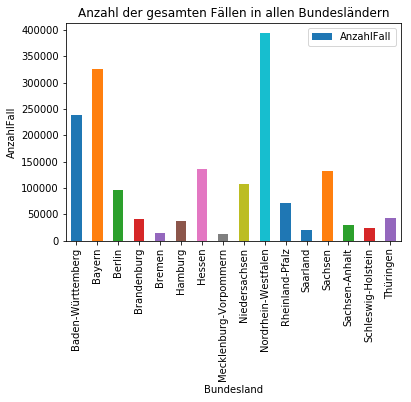

In [3]:
# accumulate cases per Bundesland

bundesland_cases_sum = data.groupby(['Bundesland'], as_index = False)['AnzahlFall'].sum()
print(bundesland_cases_sum)
bundesland_cases_sum.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Folgende Schritte werden analysiert:
- Wir haben festgestellt, dass die meisten Cases in folgenden Bundesländer vorkommen:
  Baden-Württemberg, Bayern, Berlin, Hessen, Neidersachsen, NRW, Rheinland-Pfalz und Sachsen. Diese würden wir   ein bisschen genauer anschauen, um festzustellen, welche Maßnahmen dort eingeführt waren
- Und umgekehrt wollen wir die Bunderländer betrachten, die nicht so viele Anzahl der Fällen enthalten, welche Maßnahmen sind dort eingeführt
- Vergleichen die beiden Ergebnisse -> Abhängigkeiten herausfinden?



                Bundesland  AnzahlFall
4                   Bremen     13554.0
7   Mecklenburg-Vorpommern     11993.0
11                Saarland     19879.0
13          Sachsen-Anhalt     29162.0
14      Schleswig-Holstein     24770.0


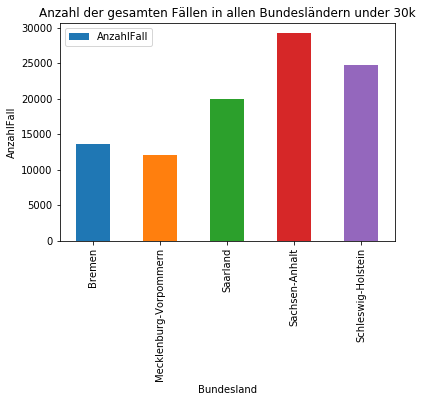

In [4]:
# making filter series for under 30k cases (general, not relatively)
filter = bundesland_cases_sum["AnzahlFall"]<30000
  
# filtering data on basis of both filters 
bundesland_cases_sum_under_30k = bundesland_cases_sum.where(filter).dropna()

print(bundesland_cases_sum_under_30k)
bundesland_cases_sum_under_30k.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern unter 30k')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

             Bundesland  AnzahlFall
0     Baden-Württemberg    237956.0
1                Bayern    324886.0
2                Berlin     96770.0
3           Brandenburg     41228.0
5               Hamburg     36394.0
6                Hessen    136513.0
8         Niedersachsen    106771.0
9   Nordrhein-Westfalen    393102.0
10      Rheinland-Pfalz     71981.0
12              Sachsen    132336.0
15            Thüringen     42027.0


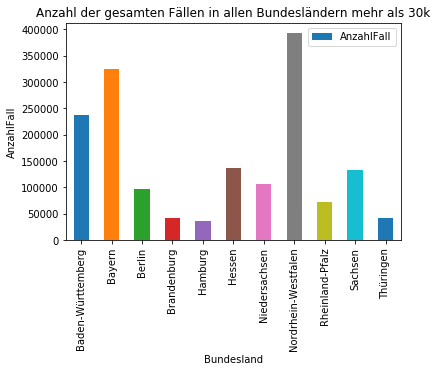

In [9]:
# making filter series for more than 30k cases (general, not relatively)
filter_more30 = bundesland_cases_sum["AnzahlFall"]>30000
  
# filtering data on basis of both filters 
bundesland_cases_sum_more_30k = bundesland_cases_sum.where(filter_more30).dropna()

print(bundesland_cases_sum_more_30k)
bundesland_cases_sum_more_30k.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern mehr als 30k')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Da wir dazu die Reproduktionszahl (R-Wert) bzw. die Anzahl der Infektionen in Bezug auf die Anzahl der Einwohner (relative) berechnen wollen, benötigen wir an der Stelle die Anzahl der Einwohner pro Bundesland. Wir greifen auf die Daten vom "Statistisches Bundesamt" zu und fügen diese zu unseren Data Frames hinzu.

                Bundesland  AnzahlFall  Inhabitants    Inzidenz  R-Value
0        Baden-Württemberg      237956     11100394   46.648935  0.12781
1                   Bayern      324886     13124737   40.397977  0.11068
2                   Berlin       96770      3669491   37.919717  0.10389
3              Brandenburg       41228      2521893   61.169424  0.16759
4                   Bremen       13554       681202   50.258374  0.13769
5                  Hamburg       36394      1847253   50.757075  0.13906
6                   Hessen      136513      6288080   46.062133  0.12620
7   Mecklenburg-Vorpommern       11993      1608138  134.089719  0.36737
8            Niedersachsen      106771      7993608   74.866846  0.20511
9      Nordrhein-Westfalen      393102     17947221   45.655380  0.12508
10         Rheinland-Pfalz       71981      4093903   56.874773  0.15582
11                Saarland       19879       986887   49.644700  0.13601
12                 Sachsen      132336      4071971

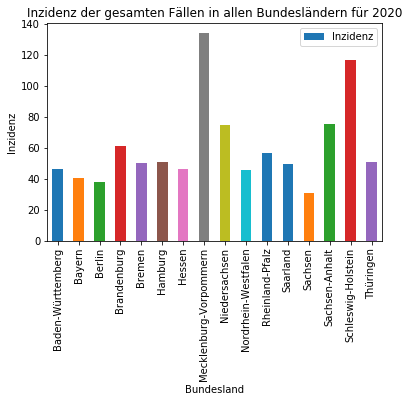

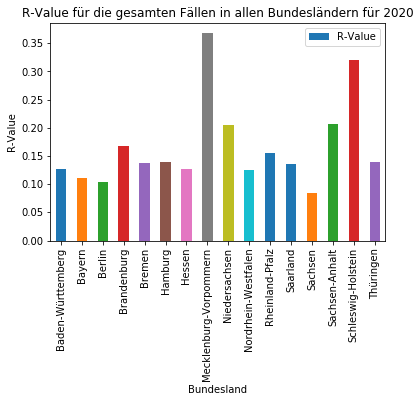

In [38]:
# add number of inhabitants, accumulate cases per Bundesland and calculate incindence & R-Wert 
# on these results 

bundesland_cases_sum = data.groupby(['Bundesland'], as_index = False)['AnzahlFall'].sum()

# Define a dictionary containing data 
data = bundesland_cases_sum
#print(data)
  
# Define a dictionary with key values of 
# an existing column and their respective 
# value pairs as the # values for our new column. 
# quelle: Statistisches Bundesamt (stand 2019)
inhabitants = {11100394 : 'Baden-Württemberg', 13124737 : 'Bayern', 3669491 : 'Berlin', 2521893 : 'Brandenburg', 
           681202 : 'Bremen', 1847253 : 'Hamburg', 6288080 : 'Hessen', 1608138 : 'Mecklenburg-Vorpommern',
           7993608 : 'Niedersachsen', 17947221 : 'Nordrhein-Westfalen', 4093903 : 'Rheinland-Pfalz', 986887 : 'Saarland',
          4071971 : 'Sachsen',2194782 : 'Sachsen-Anhalt',2903773 : 'Schleswig-Holstein',2133378 : 'Thüringen'} 
  
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data) 
  
# Provide 'Inhabitants' as the column name 
df['Inhabitants'] = inhabitants 
  
# Observe the output 
#df 

#calculate incidence and insert as a new column to the data frame
df['Inzidenz'] = df.apply(lambda row: row['Inhabitants'] / row['AnzahlFall'], axis=1)

#calculate r-value for the whole year and insert as a new column to the data frame
df['R-Value'] = round(df['Inhabitants'] / df['AnzahlFall'] / 365, 5)
print(df)

df.plot(x ='Bundesland', y='Inzidenz', kind = 'bar')

plt.title('Inzidenz der gesamten Fällen in allen Bundesländern für 2020')
plt.xlabel('Bundesland')
plt.ylabel('Inzidenz')
plt.show()

df.plot(x ='Bundesland', y='R-Value', kind = 'bar')

plt.title('R-Value für die gesamten Fällen in allen Bundesländern für 2020')
plt.xlabel('Bundesland')
plt.ylabel('R-Value')
plt.show()

                Bundesland  AnzahlFall  Inhabitants    Inzidenz  R-Value
4                   Bremen     13554.0     681202.0   50.258374  0.13769
7   Mecklenburg-Vorpommern     11993.0    1608138.0  134.089719  0.36737
11                Saarland     19879.0     986887.0   49.644700  0.13601
13          Sachsen-Anhalt     29162.0    2194782.0   75.261710  0.20620
14      Schleswig-Holstein     24770.0    2903773.0  117.229431  0.32118


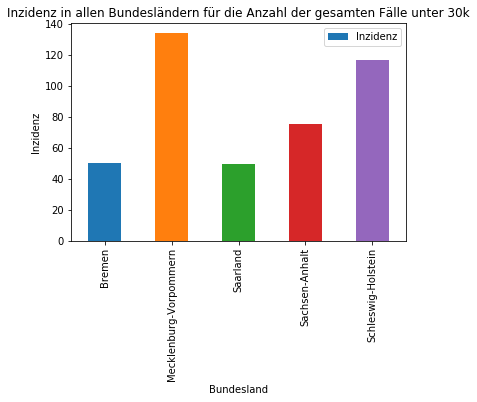

                Bundesland  AnzahlFall  Inhabitants    Inzidenz  R-Value
3              Brandenburg     41228.0    2521893.0   61.169424  0.16759
7   Mecklenburg-Vorpommern     11993.0    1608138.0  134.089719  0.36737
8            Niedersachsen    106771.0    7993608.0   74.866846  0.20511
10         Rheinland-Pfalz     71981.0    4093903.0   56.874773  0.15582
13          Sachsen-Anhalt     29162.0    2194782.0   75.261710  0.20620
14      Schleswig-Holstein     24770.0    2903773.0  117.229431  0.32118


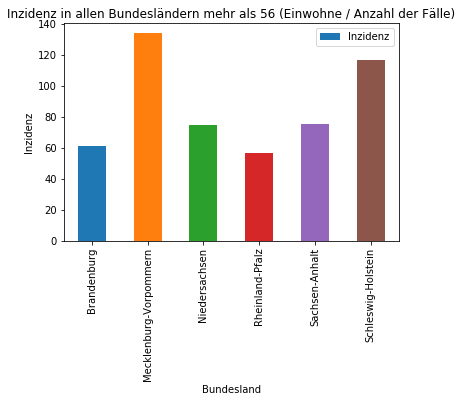

In [44]:
#filter as earlier to compare absolut and relatively cases
filter = df["AnzahlFall"]<30000
  
# filtering data on basis of both filters 
bundesland_cases_sum_under_30k = df.where(filter).dropna()

print(bundesland_cases_sum_under_30k)
bundesland_cases_sum_under_30k.plot(x ='Bundesland', y='Inzidenz', kind = 'bar')

plt.title('Inzidenz in allen Bundesländern für die Anzahl der gesamten Fälle unter 30k')
plt.xlabel('Bundesland')
plt.ylabel('Inzidenz')
plt.show()

# making filter series for incidence more than 56
filter = df["Inzidenz"]>56
  
# filtering data on basis of both filters 
incindence_cases_up_56 = df.where(filter).dropna()

print(incindence_cases_up_50)
incindence_cases_up_56.plot(x ='Bundesland', y='Inzidenz', kind = 'bar')

plt.title('Inzidenz in allen Bundesländern mehr als 56 (Einwohne / Anzahl der Fälle)')
plt.xlabel('Bundesland')
plt.ylabel('Inzidenz')
plt.show()

# Coronanet

In [59]:
if os.path.isfile('restriction_data.csv'):
    restriction_data = pd.read_csv('restriction_data.csv', encoding='iso-8859-1')
else:
    #not working with current online dataset
    #download data for restriction measures
    country = "Germany"
    url = "https://raw.githubusercontent.com/saudiwin/corona_tscs/master/data/CoronaNet/data_country/coronanet_release/coronanet_release_{0}.csv".format(country)
    restriction_data = pd.read_csv(url, encoding='iso-8859-1')
    restriction_data.to_csv("restriction_data.csv")
print("Shape: ", restriction_data.shape)
print("restriction_data.csv")

Shape:  (2687, 40)
restriction_data.csv


In [60]:
#print(restriction_data)

restriction_data['target_province'] = restriction_data['target_province'].str.replace(';','')
restriction_data['target_province'] = restriction_data['target_province'].str.replace(r'^-$','Countrywide')
restriction_data[(restriction_data.target_province.isin(['-', np.nan]))] = restriction_data[(restriction_data.target_province.isin(['-', np.nan]))].assign(target_province = 'Countrywide')

#filter=restriction_data["target_province"].str.contains('Berlin')
#add condition init_country_level = "Provincial" (, "Municipal")
#restriction_data_for_berlin = restriction_data.where(filter)#.dropna()
restriction_data_for_berlin = restriction_data[(restriction_data['target_province'] == 'Berlin') & (restriction_data['init_country_level'] == 'Provincial')]
#restriction_data_for_berlin.to_csv("restriction_data_for_berlin.csv")
#restriction_data_for_berlin.drop()
#print(restriction_data_for_berlin)

In [61]:
#List of all unique measures in Germany
print(restriction_data["type_sub_cat"].unique())

[nan 'Higher education institutions (i.e. degree granting institutions)'
 'Preschool or childcare facilities (generally for children ages 5 and below)'
 'Primary Schools (generally for children ages 10 and below)'
 'Secondary Schools (generally for children ages 10 to 18)'
 'Other External Border Restriction'
 'Health Screenings (e.g. temperature checks)'
 'Travel History Form (e.g. documents where traveler has recently been)'
 'Visa extensions (e.g. visa validity extended)' 'Health Certificates'
 'Hand Sanitizer' 'Other Health Materials' 'Temporary Medical Centers'
 'Public Testing Facilities (e.g. drive-in testing for COVID-19)'
 'Health Research Facilities' 'Ventilators' 'Unspecified Health Materials'
 'Hospitals' 'Other Heath Staff' 'Doctors'
 'Unspecified Health Infrastructure' 'Nurses' 'Health Volunteers'
 'Unspecified Health Staff' 'Masks' 'Other Health Infrastructure'
 'Personal Protective Equipment' 'Temporary Quarantine Centers'
 'Medicine/Drugs' 'Test Kits'
 'Fixed Health Te

In [58]:
#Comparison, number of measures in different BL (Ranking)
restriction_data_by_province = restriction_data.groupby(['target_province'], as_index = False).sum()
#df.groupby(['Fruit','Name']).sum()
print(restriction_data_by_province)

                                  target_province  Unnamed: 0   policy_id  \
0                                  -_Lower Saxony         673     9197942   
1                              Baden-Wuerttemberg      814365  2513821698   
2           Baden-Wuerttemberg_Baden-Wuerttemberg        2314    15526598   
3                                         Bavaria      209909  1022127789   
4                                 Bavaria_Bavaria        9668    66463025   
5                     Bayern Baden-WÃÂ¼rttemberg         359     3950578   
6                                          Berlin      268719  1021607655   
7                  Berlin Brandenburg_Brandenburg        1482       57615   
8                                   Berlin_Berlin        3975    47904849   
9                                     Brandenburg       82981   383544571   
10                        Brandenburg_Brandenburg        5307    40992489   
11                                         Bremen      267318  1068948434   

Todo:
- List of all unique measures in Germany with category
- Comparison, number of measures in different BL (Ranking), maybe add case numbers
- List of countrywide measures
- maybe: ranking, most popular/long-lived measures
- maybe: timeline of all measures per BL